<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Comparing EOF packages

---

## Overview
If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import CenteredNorm
from scipy import stats, signal
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from xeofs.xarray import EOF
from eofs.xarray import Eof

We will use the [Extended Reconstructed Sea Surface Temperature](https://www.ncei.noaa.gov/products/extended-reconstructed-sst) (ERSST) version 3b dataset from NOAA, which is included locally in this cookbook. As an example, we will calculate and plot a timeseries for an index of the Pacific Decadal Oscillation (PDO), specifically the leading mode of SST variability in the North Pacific.

In [2]:
sst = xr.open_dataset('./data/sst.mnmean.nc')
sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 1994, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Extended Reconstructed SST V3b
    Conventions:    CF-1.0
    history:        Thu Jul  1 14:03:49 2010: ncatted -O -a _FillValue,sst,o,...
    comments:       The extended reconstructed sea surface temperature (ERSST...
    platform:       Model
    source:         NOAA/NESDIS/National Climatic Data Center
    institution:    NOAA/NESDIS/National Climatic Data Center
    citation:       Smith, T.M., R.W. Reynolds, Thomas C. Peterson, and Jay L...
    dataset_title:  Extended Reconstructed Sea Surface Temperature (ERSST)
    source_doc:     https://www.ncdc.noaa.gov/data-access/marineocean-data/ex...
    data_modified:  2020-03-03
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.ersst.html

In [3]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

In [4]:
sst_clim = sst.groupby('time.month')
ssta = sst_clim - sst_clim.mean(dim='time')
ssta_dt = (ssta - global_average(ssta)).squeeze()

In [5]:
ssta_dt

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 1994, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1 2
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 -0.002464 -0.002464 ... 0.002464 0.002464
    sst        (time, lat, lon) float32 0.06198 0.06198 0.06198 ... nan nan nan

In [6]:
np_ssta_dt = ssta_dt.where((ssta_dt.lat < 70) & (ssta_dt.lat > 20) & (ssta_dt.lon > 120) & (ssta_dt.lon < 260), drop=True)

### Using xeofs

In [7]:
np_model_xeofs = EOF(np_ssta_dt.sst, n_modes=5, dim=['time'], norm=True, weights='coslat')
np_model_xeofs.solve()
np_eofs_xeofs = np_model_xeofs.eofs()
np_pcs_xeofs = np_model_xeofs.pcs()
expvar = np_model_xeofs.explained_variance_ratio()

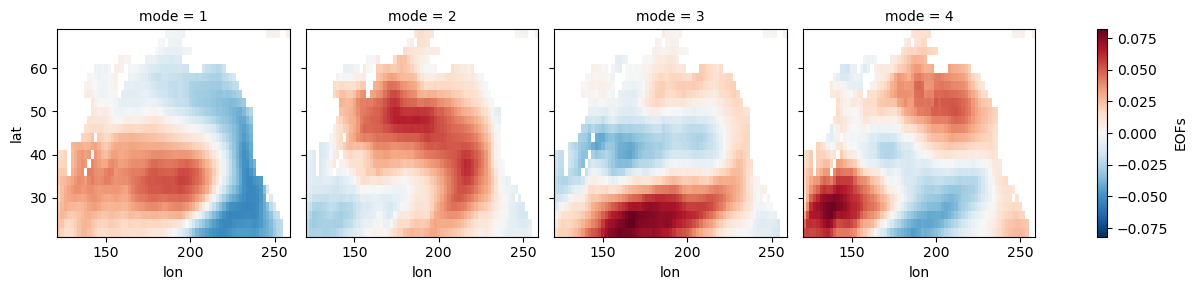

In [8]:
np_eofs_xeofs.isel(mode=[0, 1, 2, 3]).plot(col='mode')

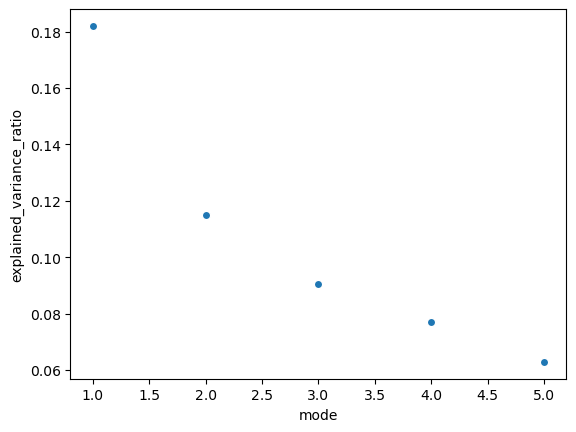

In [9]:
expvar.plot.scatter()

Text(0.5, 1.0, 'PDO Index (detrended North Pacific SSTA EOF1)')

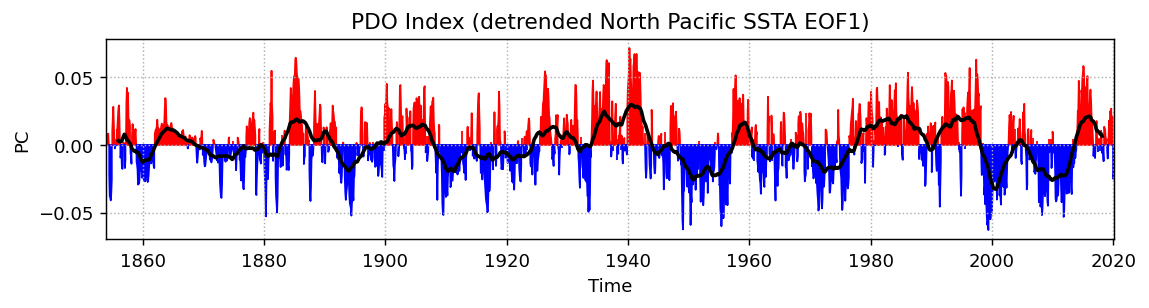

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi=130)
plt.fill_between(np_pcs_xeofs.time, -np_pcs_xeofs.isel(mode=0).where(np_pcs_xeofs.isel(mode=0) < 0), color='r')
plt.fill_between(np_pcs_xeofs.time, -np_pcs_xeofs.isel(mode=0).where(np_pcs_xeofs.isel(mode=0) > 0), color='b')
plt.plot(np_pcs_xeofs.time, -np_pcs_xeofs.isel(mode=0).rolling(time=48, center=True).mean(), color='k', linewidth=2)
plt.ylabel('PC')
plt.xlabel('Time')
plt.xlim(np_pcs_xeofs.time.min(), np_pcs_xeofs.time.max())
plt.grid(linestyle=':')
plt.title('PDO Index (detrended North Pacific SSTA EOF1)')

### Using eofs

In [12]:
# Seems like this is currently broken: 
# https://stackoverflow.com/questions/71740621/eofs-xarray-raising-typeerror-using-a-dataarray-to-construct-a-variable-is-ambi

coslat = np.cos(np.deg2rad(np_ssta_dt.coords['lat'].values))
wgts = coslat[..., np.newaxis]

solver = Eof(np_ssta_dt.sst, weights=wgts)
np_eofs_eofs = solver.eofs(neofs=5)
np_pcs_eofs = solver.pcs(npcs=5, pcscaling=1)
varfrac = solver.varianceFraction()

TypeError: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!